Here we'll want to investigate how the distances vary across the cheese.

In [1]:
import qiime2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gneiss.util import match
from skbio import DistanceMatrix
from skbio.stats.composition import closure
import matplotlib.cm as cmx
import matplotlib.colors as colors

%matplotlib inline

The OTU tables that we will be analyzing are in a qiime2 archive format, so we'll want to extract those contents.

In [2]:
table = qiime2.Artifact.load('16S_table.biom.qza').view(pd.DataFrame)

# filter out bad samples and OTUs
table = table.loc[table.sum(axis=1)>50, table.sum(axis=0)>0]

metadata = pd.read_table('sample_prep.txt', index_col=0, na_values='Not applicable')

metadata = metadata.loc[pd.notnull(metadata['grid_position'])]
# extract only the bonde cheese
metadata = metadata.loc[metadata['ANONYMIZED_NAME']=='Bonde']

# convert the rows and columns into numbers
metadata['grid_column'] = metadata.grid_position.apply(lambda x: ord(x[0])-ord('A'))
metadata['grid_row'] = metadata.grid_position.apply(lambda x: x[1:])
metadata['grid_row'] = metadata.grid_row.astype(np.int)
metadata['grid_column'] = metadata.grid_column.astype(np.int)

table, metadata = match(table, metadata)

In [3]:
# Jenssen Shannon Distance
from scipy.stats import entropy
def KL(x, y):
    idx = np.logical_or(x>0, y>0)
    return entropy(x[idx], y[idx])

def jsd(x, y):
    n1 = x.sum()
    n2 = y.sum()
    return np.sqrt(0.5 * (KL(x,(n1/(n1+n2))*(x+y)) + KL(y,(n2/(n1+n2))*(x+y))))

In [4]:
jsd_dm = DistanceMatrix.from_iterable(closure(table.values), jsd)
jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)

In [5]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row) < 2):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

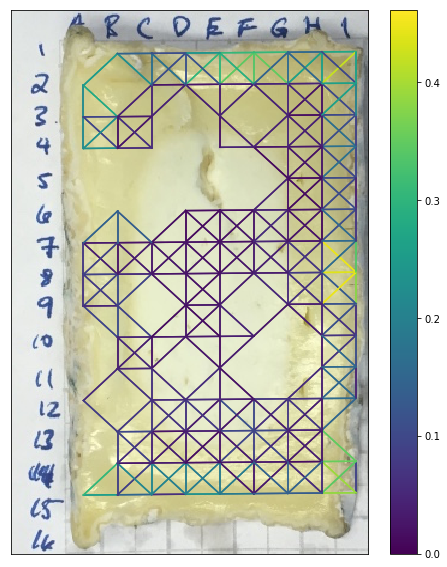

In [6]:
fig = plt.figure(figsize=(8, 10))
im = plt.imread('bonde_cheese_img.png')
implot = plt.imshow(im, interpolation='nearest', aspect='auto')
edges_x = []
edges_y = []
edges_c = []
cNorm  = colors.Normalize(vmin=0, vmax=jsd_dm.max().max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
scalarMap.set_array([])
for pair in pairs.values:
    src, dest = pair
    src_x, src_y = metadata.loc[src, ['x', 'y']]
    dest_x, dest_y = metadata.loc[dest, ['x', 'y']]
    edges_x = [src_x, dest_x]
    edges_y = [src_y, dest_y]
    d = jsd_dm.loc[src, dest]
    colorVal = scalarMap.to_rgba(d)
    #color = plt.cm.Reds(norm(pval))
    edges_c = [colorVal, colorVal]
    plt.plot(edges_x, edges_y, color=colorVal)
plt.grid('off')
plt.colorbar(scalarMap)
_ = plt.xticks([])
_ = plt.yticks([]) 

In [7]:
table = table.astype(np.int)

In [8]:
from numpy.random import choice
from skbio.stats import subsample_counts
from itertools import product

# Scaling function
def scaling_function(f, x, y, k=10, N=1000):
    ds = np.zeros(k)
    xs = np.zeros((k, len(x)))
    ys = np.zeros((k, len(y)))
    for i in range(k):
        xs[i, :] = subsample_counts(x, N, replace=True)
        ys[i, :] = subsample_counts(y, N, replace=True)

    x_pairs = [f(xs[i, :], xs[j, :]) for i, j in product(range(k), range(k))]
    y_pairs = [f(ys[i, :], ys[j, :]) for i, j in product(range(k), range(k))]
    xy_pairs = [f(xs[i, :], ys[j, :]) for i, j in product(range(k), range(k))]
    x_std = np.std(x_pairs)
    y_std = np.std(y_pairs)
    return np.mean(xy_pairs) / np.min((x_std, y_std))
from skbio.stats.distance import DissimilarityMatrix

jsd_scaled = lambda x, y: scaling_function(jsd, x, y)
jsd_dm = DissimilarityMatrix.from_iterable(table.values, jsd_scaled)
jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)

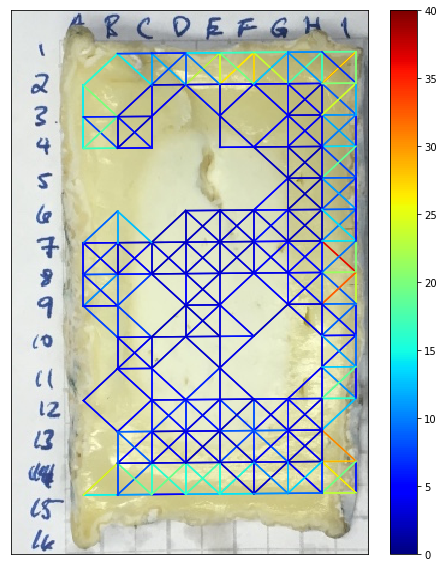

In [10]:
fig = plt.figure(figsize=(8, 10))
im = plt.imread('bonde_cheese_img.png')
implot = plt.imshow(im, interpolation='nearest', aspect='auto')
edges_x = []
edges_y = []
edges_c = []
cNorm  = colors.Normalize(vmin=0, vmax=40)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
scalarMap.set_array([])
for pair in pairs.values:
    src, dest = pair
    src_x, src_y = metadata.loc[src, ['x', 'y']]
    dest_x, dest_y = metadata.loc[dest, ['x', 'y']]
    edges_x = [src_x, dest_x]
    edges_y = [src_y, dest_y]
    d = jsd_dm.loc[src, dest]
    colorVal = scalarMap.to_rgba(d)
    #color = plt.cm.Reds(norm(pval))
    edges_c = [colorVal, colorVal]
    plt.plot(edges_x, edges_y, color=colorVal)
plt.grid('off')
plt.colorbar(scalarMap)
_ = plt.xticks([])
_ = plt.yticks([]) 

In [35]:
boot_pairs = [('bonde.G2', 'bonde.G3'),
              ('bonde.H2', 'bonde.I1'), 
              ('bonde.H7', 'bonde.I8')]

def scaling_function(f, x, y, k=100, N=10000):
    ds = np.zeros(k)
    for i in range(k):
        xs = subsample_counts(x, N, replace=True)
        ys = subsample_counts(y, N, replace=True)
        ds[i] = f(xs, ys)
    return ds

def plot_distance_histograms(j, a, l1, l2, ax1, ax2, ax3, ax4, color):
    sns.distplot(j, ax=ax1, color=color)
    ax1.set_title('Jenssen Shannon')

    sns.distplot(a, ax=ax2, color=color)
    ax2.set_title('Aitchison')

    sns.distplot(l1, ax=ax3, color=color)
    ax3.set_title('L1')

    sns.distplot(l2, ax=ax4, color=color)
    ax4.set_title('L2')


In [36]:
# L1 distance
from scipy.spatial.distance import cityblock
L1 = cityblock

# L2 distance
from scipy.spatial.distance import euclidean
L2 = euclidean

# Aitchison distance
from skbio.stats.composition import clr, multiplicative_replacement
aitchison = lambda x, y: euclidean(clr(multiplicative_replacement(x, delta=0.000001)), 
                                   clr(multiplicative_replacement(y, delta=0.000001)))

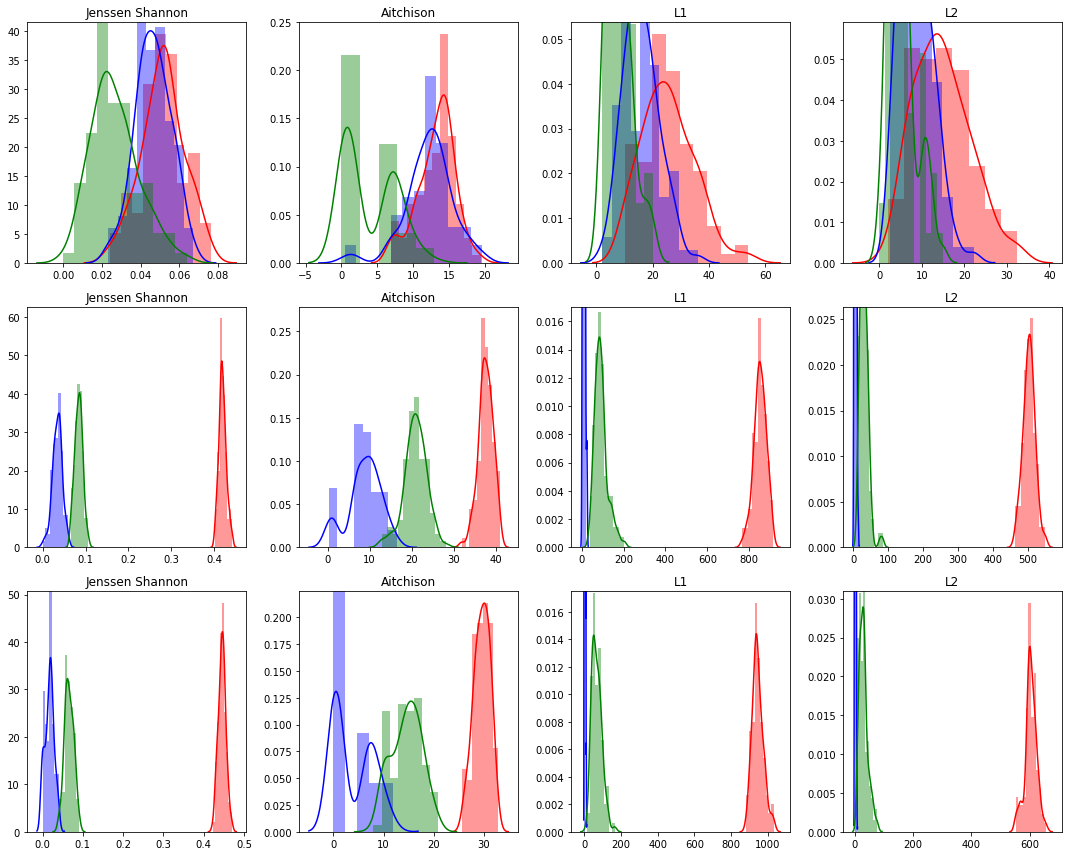

In [43]:
import seaborn as sns
fig, ax = plt.subplots(3, 4, figsize=(15, 12), sharey=False)
boots = 100
depth = 1000
for i, p in enumerate(boot_pairs):
    p1, p2 = p
    # across distances
    jsd_boots = scaling_function(jsd, x=table.loc[p1], 
                                 y=table.loc[p2], k=boots, N=depth) 
    L1_boots = scaling_function(L1, x=table.loc[p1], 
                                y=table.loc[p2], k=boots, N=depth)
    L2_boots = scaling_function(L2, x=table.loc[p1], 
                                y=table.loc[p2], k=boots, N=depth)
    aitchison_boots = scaling_function(aitchison, x=table.loc[p1],
                                       y=table.loc[p2], k=boots, N=depth)
    plot_distance_histograms(jsd_boots, aitchison_boots, 
                             L1_boots, L2_boots, 
                             ax[i][0], ax[i][1], 
                             ax[i][2], ax[i][3], color='red')

    # within distances
    
    jsd_same_boots = scaling_function(jsd, x=table.loc[p1], 
                                      y=table.loc[p1], k=boots, N=depth) 
    L1_same_boots = scaling_function(L1, x=table.loc[p1], 
                                     y=table.loc[p1], k=boots, N=depth)
    L2_same_boots = scaling_function(L2, x=table.loc[p1], 
                                     y=table.loc[p1], k=boots, N=depth)
    aitchison_same_boots = scaling_function(aitchison, x=table.loc[p1],
                                            y=table.loc[p1], k=boots, N=depth)
    plot_distance_histograms(jsd_same_boots, aitchison_same_boots, 
                             L1_same_boots, L2_same_boots, 
                             ax[i][0], ax[i][1], 
                             ax[i][2], ax[i][3], color='blue')
    
    jsd_same_boots = scaling_function(jsd, x=table.loc[p2], 
                                      y=table.loc[p2], k=boots, N=depth) 
    L1_same_boots = scaling_function(L1, x=table.loc[p2], 
                                     y=table.loc[p2], k=boots, N=depth)
    L2_same_boots = scaling_function(L2, x=table.loc[p2], 
                                     y=table.loc[p2], k=boots, N=depth)
    aitchison_same_boots = scaling_function(aitchison, x=table.loc[p2],
                                            y=table.loc[p2], k=boots, N=depth)
    plot_distance_histograms(jsd_same_boots, aitchison_same_boots, 
                             L1_same_boots, L2_same_boots, 
                             ax[i][0], ax[i][1], 
                             ax[i][2], ax[i][3], color='green')
    
plt.tight_layout()